# Data Cleaning & EDA 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import re
from functions import top_words_subreddit

In [2]:
df_b = pd.read_csv('./data/raw_scrapes/combined_buddhism_scrapes.csv')
df_b.head() 

,title,selftext,subreddit,created_utc,name,upvote ratio,num_upvotes
0,Buddha’s Four Noble Truths for a four year old,NaN,Buddhism,1.614250e+09,t3_ls3y66,0.98,3879
1,Thic Nhat Hanh has passed away,NaN,Buddhism,1.642795e+09,t3_s9j9q9,0.98,3731
2,Drew this last night. Buddhism has enriched my...,NaN,Buddhism,1.486483e+09,t3_5sm4r9,0.91,3667
3,Made this Buddha painting,NaN,Buddhism,1.603192e+09,t3_jen9kf,0.98,3493
4,Found this video that compares mindfulness to ...,NaN,Buddhism,1.631042e+09,t3_pjto21,0.98,3336


In [3]:
df_s = pd.read_csv('./data/raw_scrapes/combined_stoicism_scrapes.csv')
df_s.head()

,title,selftext,subreddit,created_utc,name,upvote ratio,num_upvotes
0,Looking for Seneca's quote on why even bed fle...,I think it was Seneca who wrote something alon...,Stoicism,1.705696e+09,t3_19aswwj,0.67,1
1,READ BEFORE POSTING: r/Stoicism beginner's gui...,"Welcome to the r/Stoicism subreddit, a forum f...",Stoicism,1.705694e+09,t3_19as7c7,0.76,2
2,The New Agora: Daily WWYD and light discussion...,"Welcome to the New Agora, a place for you and ...",Stoicism,1.705694e+09,t3_19as6qt,0.76,2
3,My biggest life mistake was wanting to live an...,"2023 summons this the best, I didn’t want to e...",Stoicism,1.705691e+09,t3_19aqv6w,0.94,27
4,What’s your favorite way to practice gratitude...,You can mention some relevant quotes as well.,Stoicism,1.705691e+09,t3_19aqp1z,1.00,3


### Removal of Nulls and Duplicates

In [4]:
print('b:',df_b.shape)
print('s:',df_s.shape)
# Check for duplicates in the name column - name is a unique post identifier allocated by reddit 
duplicates_b = df_b.duplicated(subset=['name', 'selftext'])
print('b duplicates:',duplicates_b.sum())
duplicates_s = df_s.duplicated(subset=['name', 'selftext'])
print('s duplicates:',duplicates_s.sum())

b: (29562, 7)
s: (28995, 7)
b duplicates: 26281
s duplicates: 25934


In [5]:
# Drop duplicates in the name column 
df_b.drop_duplicates(subset='name', inplace=True)
df_s.drop_duplicates(subset='name', inplace=True)
print('b:',df_b.shape)
print('s:',df_s.shape)

b: (3279, 7)
s: (3057, 7)


In [6]:
df_b.isnull().sum()

title              0
selftext        1480
subreddit          0
created_utc        0
name               0
upvote ratio       0
num_upvotes        0
dtype: int64

In [7]:
df_s.isnull().sum()

title             0
selftext        747
subreddit         0
created_utc       0
name              0
upvote ratio      0
num_upvotes       0
dtype: int64

In [8]:
# Combine dataframes together and create combined title with column with selftext columns 
df = pd.concat([df_s, df_b])
df['selftext'].fillna('', inplace=True)
df['combined_text'] = df['title']+ ' ' +df['selftext']
df.isna().sum()

title            0
selftext         0
subreddit        0
created_utc      0
name             0
upvote ratio     0
num_upvotes      0
combined_text    0
dtype: int64

### Make Target Feature and EDA

In [9]:
# Create target column and features
df['is_stoicism'] = df['subreddit'].map({'Stoicism' : 1, 'Buddhism' : 0})

In [10]:
df.describe()

,created_utc,upvote ratio,num_upvotes,is_stoicism
count,6.336000e+03,6336.000000,6336.000000,6336.000000
mean,1.629753e+09,0.754741,356.663826,0.482481
std,9.143643e+07,0.215018,706.450034,0.499732
min,1.220829e+09,0.060000,0.000000,0.000000
25%,1.584717e+09,0.540000,1.000000,0.000000
50%,1.661593e+09,0.790000,7.000000,0.000000
75%,1.703970e+09,0.980000,610.250000,1.000000
max,1.706300e+09,1.000000,11939.000000,1.000000


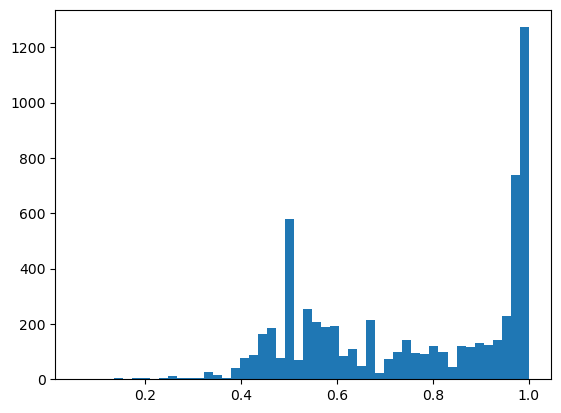

In [11]:
plt.hist(df['upvote ratio'], bins=50);

- Upvote ratio distribution is skewed left - most posts have more up votes than downvotes suggesting if people are inclinded to vote it is usually in a positive direction.<br/>
- Spike at 0.5 likely suggests posts that had no votes, this idea supported by the grpah below showing many posts with no upvotes.<br/>

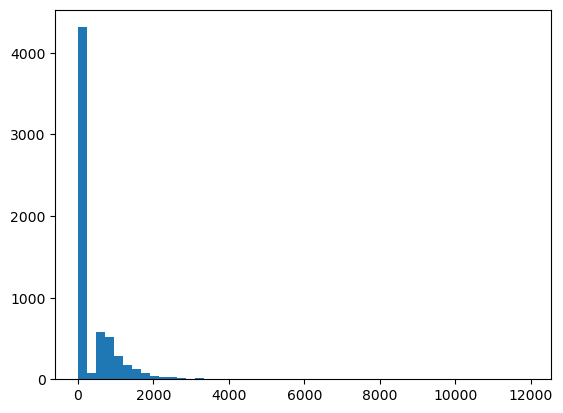

In [12]:
plt.hist(df['num_upvotes'], bins=50);

- Num_upvotes skewed right, most posts have very few and some have lots. This is unsuprising in many ways, most posts recieve very little attention but some recieve a lot of attention and many upvotes.<br/>
- There are some exteme outliers suggesting some viral posts.<br/>

In [13]:
# Check punctiation in df 
df['combined_text'].str.contains(r'[^\w\s]').sum()

5869

In [14]:
# Remove punctuation from df 
# Source: https://www.includehelp.com/python/fast-punctuation-removal-with-pandas.aspx
df['combined_text'] = df['combined_text'].str.replace(r'[^\w\s]+', '', regex=True)
df['combined_text'].str.contains(r'[^\w\s]').sum()  # check 

0

In [15]:
# Create a variable for word count per submission
def word_count(text):
    try: 
        length = len(text.split())
    except ValueError:
        pass
    return length

df['word_count'] = df['combined_text'].apply(word_count)

In [16]:
df.groupby('subreddit')['word_count'].sum()

subreddit
Buddhism    327513
Stoicism    436787
Name: word_count, dtype: int64

In [17]:
df.groupby('subreddit')['word_count'].median()

subreddit
Buddhism    34.0
Stoicism    83.0
Name: word_count, dtype: float64

In [18]:
df.groupby('subreddit')['word_count'].mean()

subreddit
Buddhism     99.881976
Stoicism    142.880929
Name: word_count, dtype: float64

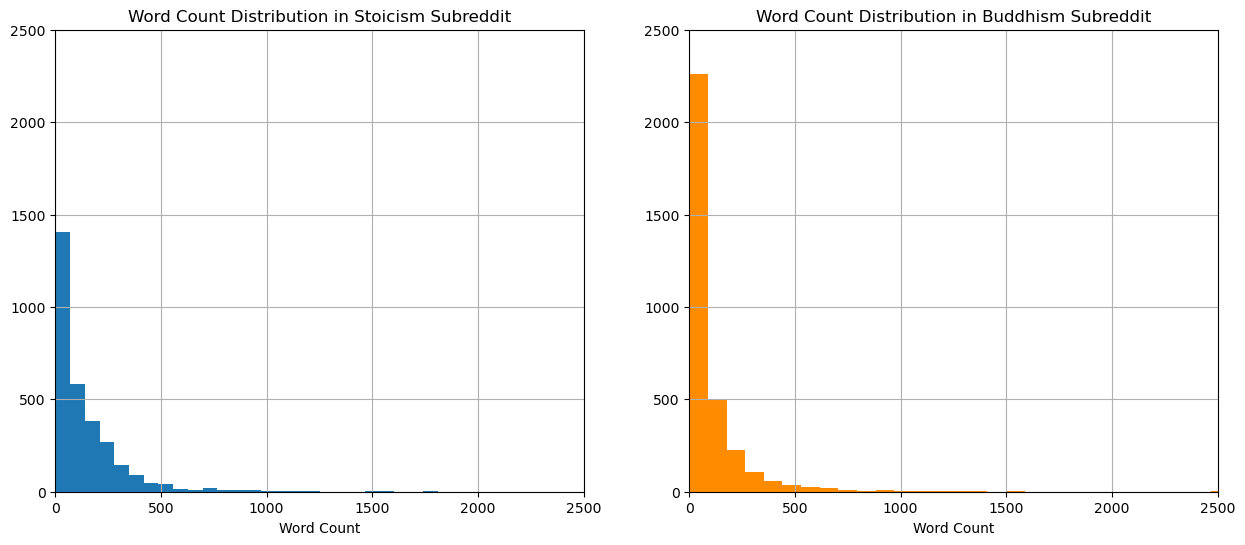

In [19]:
# Create histograms to visualise word count by subreddit 
stoicism_df = df[df['subreddit'] == 'Stoicism']
buddhism_df = df[df['subreddit'] == 'Buddhism']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(stoicism_df['word_count'], bins=30)
axs[0].set_title('Word Count Distribution in Stoicism Subreddit')
axs[0].set_xlabel('Word Count')
axs[0].set_xlim(0, 2500)
axs[0].set_ylim(0, 2500) 
axs[0].grid(True)

axs[1].hist(buddhism_df['word_count'], bins=30, color = 'DarkOrange')
axs[1].set_title('Word Count Distribution in Buddhism Subreddit')
axs[1].set_xlabel('Word Count')
axs[1].set_xlim(0, 2500)
axs[1].set_ylim(0, 2500) 
axs[1].grid(True);

- Fairly similar distributions. 
- As to be expected from means obvserved, Stoicism distibution has fewer short length posts and a slightly wider distribution of word count. 
- There are 25% more words in the stoicism corpus, which might suggest the model will be better at identifying the positive class (the stoicism subreddits), based on the idea that more data leads to more accurate classification. 

### View top appearing words by subreddit:
Function defined in file functions.py included in project folder.

In [20]:
# Create df of anf view top 50 occuring words - see functions.py for defined function 
top_words_bysubreddit = top_words_subreddit(df)
top_words_bysubreddit.head(20)

,buddhism,stoicism
to,14276.0,11556.0
the,13967.0,11125.0
and,12679.0,10375.0
of,8860.0,7159.0
is,6399.0,4960.0
that,6359.0,5012.0
in,6218.0,5173.0
you,5699.0,3962.0
it,5254.0,4062.0
my,5000.0,4338.0


In [21]:
# Top appearing overall 
top_words = top_words_subreddit(df, bysubreddit=False, i = 50)
top_words

the       26734
to        24683
and       21655
of        16894
is        11976
in        11612
that      10769
it         9101
you        8587
my         7903
this       7181
for        6715
but        5675
not        5578
have       5431
with       5379
be         5336
me         5142
as         4994
or         4865
are        4771
on         4658
what       4070
if         3957
was        3822
do         3735
so         3493
about      3404
how        3193
we         3180
can        3174
im         3135
like       3089
from       3013
all        2903
your       2900
just       2674
they       2643
life       2548
by         2402
at         2373
its        2320
one        2271
people     2270
am         2264
dont       2251
he         2250
would      2182
an         2148
when       2140
dtype: int64

In [22]:
# View topwords as a list 
top_words.index

Index(['the', 'to', 'and', 'of', 'is', 'in', 'that', 'it', 'you', 'my', 'this',
       'for', 'but', 'not', 'have', 'with', 'be', 'me', 'as', 'or', 'are',
       'on', 'what', 'if', 'was', 'do', 'so', 'about', 'how', 'we', 'can',
       'im', 'like', 'from', 'all', 'your', 'just', 'they', 'life', 'by', 'at',
       'its', 'one', 'people', 'am', 'dont', 'he', 'would', 'an', 'when'],
      dtype='object')

In [23]:
# View top bigrams by subreddit
# NaN means it occurs in the top 20 for on category (subreddit) but not for the other 
top_bigrams = top_words_subreddit(df, ngram=(2,2), i = 20)
top_bigrams.head(20)

,buddhism,stoicism
in the,1233.0,979.0
to be,1131.0,843.0
of the,1085.0,902.0
if you,675.0,512.0
it is,656.0,495.0
to the,630.0,526.0
you are,560.0,439.0
want to,547.0,467.0
this is,480.0,396.0
to do,469.0,392.0


Again we see here many pronouns, prepositions and conjunctions - words which are typically excluded using standardised stop words lists. 

In [24]:
# View top trigrams by subreddit
top_trigrams = top_words_subreddit(df, ngram=(3,3), i = 20)
top_trigrams.head(20)

,buddhism,stoicism
if you are,190.0,171.0
the new agora,184.0,192.0
in my life,108.0,86.0
to deal with,107.0,82.0
dont want to,97.0,93.0
in the new,93.0,97.0
if you have,91.0,78.0
one of the,87.0,82.0
there is no,83.0,66.0
be able to,81.0,63.0


By listing out trigrams we have seen there are lot of links in the text: "www reddit com", "https www reddit". URLs are searched for and counted below as well as emojis. 

In [25]:
# Check for the presence of URLs in the corpus
df['contains_https'] = df['combined_text'].str.contains('https|www')

# group by subreddit and show counts of rows that contain https 
count_https = df.groupby('subreddit')['contains_https'].sum()
count_https

subreddit
Buddhism    182
Stoicism    221
Name: contains_https, dtype: int64

In [26]:
# use regex to locate and count of rows that contain emojis (not the total number of emojis across the corpus)
# Sources: https://gist.github.com/n1n9-jp/5857d7725f3b14cbc8ec3e878e4307ce 
# https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def contains_emoji(x):
    emoji_pattern = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return bool(emoji_pattern.search(x))

# create a new column for the presence of emojis
df['contains_emoji'] = df['combined_text'].apply(contains_emoji)

# group by subreddit and show counts
emoji_counts = df.groupby('subreddit')['contains_emoji'].sum()
emoji_counts

subreddit
Buddhism    0
Stoicism    0
Name: contains_emoji, dtype: int64

In [27]:
# baseline is 51% of posts are in the negative class (buddhism) subreddit
df['is_stoicism'].value_counts(normalize=True) # find baseline 


is_stoicism
0    0.517519
1    0.482481
Name: proportion, dtype: float64

In [28]:
# export cleaned and combined dataframe 
pd.DataFrame.to_csv(df, './data/stoicism_buddhism_clean.csv', index=False)

**Cleaning & EDA Summary**<br/>

- Removed duplicate rows from dataframes.<br/>
- Combined the dataframes into one.<br/>
- Noted a high proportion of posts with no self-text; merged the self-text and title columns to create a combined column.<br/>
- Created the numerical target variable 'is_stoicism', where 1 represents posts from the stoicism subreddit and 0 represents posts from the Buddhism subreddit.<br/>
- Removed punctuation from text.<br/>
- Created a word count column, finding, on average, Buddhism posts were 100 words long and Stoicism posts were 143 words long.<br/>
- Found total word count for Buddhism: 327,513; for Stoicism: 436,787.<br/>
- Plotted a word count histogram, which indicated that Stoicism submissions have fewer very short-length posts.<br/>
- Created a function 'top_words_subreddit', stored in functions.py. This function takes in a dataframe and outputs the 50 top-appearing words in each subreddit. The purpose is to aid with stop word selection and to identify common and unique words in each subreddit, which could be useful for understanding overfitting and for later stages of the analysis.<br/>
- Initial list of most frequent words suggests that removing stop words might be beneficial if our model overfits.<br/>
- The prevalence of many frequently occurring shared words suggests considering the use of TF-IDF in preprocessing. TF-IDF downweights terms that appear frequently across documents, thus emphasizing words that are more unique to specific documents. This approach may be particularly useful to counter potential overfitting.<br/>
- Checked top-appearing trigrams, revealing a significant presence of URLs in the corpus.<br/>
- Determined that about 6% of all submissions contain URLs and removed these from the corpus.<br/>
- Found that approximately 3% of documents contain emojis, removed emojis from corpus.<br/>
- Identified a baseline score of 51% for non-stoicism posts, indicating a relatively even class balance for analysis. 51% of posts are from the Buddhism subreddit.<br/>
- Exported the combined and cleaned dataset as 'stoicism_buddhism_clean.csv' for use in further notebooks.<br/>

**Looking Ahead:**
- Confident - given what has been discovered during ED - that there is sufficent data to build an accurate (above 90%) classification model. 
- There are more buddhism posts than stoicism the class balance is very even which is helpful for modeling. Our baseline score is close to 50/50 and the model will have to learn from the text in the corpus to classify accurately. 
- There are 25% more words in the stoicism corpus, which might suggest the model will be better at identifying the positive class (the stoicism subreddits), based on the idea that more data leads to more accurate classification. 
- Look to stop-words, stemming and TF-IDF in next stages to remove noise.